In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats.distributions as dist

In [2]:
da = pd.read_csv("nhanes_2015_2016.csv")

da["SMQ020x"] = da.SMQ020.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})  # np.nan represents a missing value
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})
da["DMDCITZNx"] = da.DMDCITZN.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})

In [3]:
x = da.SMQ020x.dropna() == "Yes"
p = x.mean()
se = np.sqrt(0.4 * 0.6 / len(x))
test_stat = (p - 0.4) / se
pvalue = 2*dist.norm.cdf(-np.abs(test_stat))
print(test_stat, pvalue)

0.7823563854332805 0.4340051581348052


In [4]:
# Prints test statistic, p-value
print(sm.stats.proportions_ztest(x.sum(), len(x), 0.4)) # Normal approximation with estimated proportion in SE
print(sm.stats.proportions_ztest(x.sum(), len(x), 0.4, prop_var=0.4)) # Normal approximation with null proportion in SE

# Prints the p-value
print(sm.stats.binom_test(x.sum(), len(x), 0.4)) # Exact binomial p-value

(0.7807518954896244, 0.43494843171868214)
(0.7823563854332805, 0.4340051581348052)
0.4340360854459431


In [5]:
dx = da[["SMQ020x", "RIDAGEYR", "RIAGENDRx"]].dropna()  # Drop missing values
dx = dx.loc[(dx.RIDAGEYR >= 20) & (dx.RIDAGEYR <= 25), :] # Restrict to people between 20 and 25 years old

# Summarize the data by caclculating the proportion of yes responses and the sample size
p = dx.groupby("RIAGENDRx")["SMQ020x"].agg([lambda z: np.mean(z=="Yes"), "size"])
p.columns = ["Smoke", "N"]
print(p)

# The pooled rate of yes responses, and the standard error of the estimated difference of proportions
p_comb = (dx.SMQ020x == "Yes").mean()
va = p_comb * (1 - p_comb)
se = np.sqrt(va * (1 / p.N.Female + 1 / p.N.Male))

# Calculate the test statistic and its p-value
test_stat = (p.Smoke.Female - p.Smoke.Male) / se
pvalue = 2*dist.norm.cdf(-np.abs(test_stat))
print(test_stat, pvalue)

              Smoke    N
RIAGENDRx               
Female     0.238971  272
Male       0.341270  252
-2.5833303066279414 0.009785159057508375


In [6]:
dx_females = dx.loc[dx.RIAGENDRx=="Female", "SMQ020x"].replace({"Yes": 1, "No": 0})
dx_males = dx.loc[dx.RIAGENDRx=="Male", "SMQ020x"].replace({"Yes": 1, "No": 0})
sm.stats.ttest_ind(dx_females, dx_males) # prints test statistic, p-value, degrees of freedom

(-2.5949731446269344, 0.00972590232121254, 522.0)

In [7]:
dx = da[["BPXSY1", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx = dx.loc[(dx.RIDAGEYR >= 40) & (dx.RIDAGEYR <= 50) & (dx.RIAGENDRx == "Male"), :]
print(dx.BPXSY1.mean()) # prints mean blood pressure
sm.stats.ztest(dx.BPXSY1, value=120)  # prints test statistic, p-value

125.86698337292161


(7.469764137102597, 8.033869113167905e-14)

In [8]:
dx = da[["BPXSY1", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx = dx.loc[(dx.RIDAGEYR >= 50) & (dx.RIDAGEYR <= 60), :]
bpx_female = dx.loc[dx.RIAGENDRx=="Female", "BPXSY1"]
bpx_male = dx.loc[dx.RIAGENDRx=="Male", "BPXSY1"]
print(bpx_female.mean(), bpx_male.mean()) # prints female mean, male mean
print(sm.stats.ztest(bpx_female, bpx_male)) # prints test statistic, p-value
print(sm.stats.ttest_ind(bpx_female, bpx_male)) # prints test statistic, p-value, degrees of freedom

127.92561983471074 129.23829787234044
(-1.105435895556249, 0.2689707570859362)
(-1.105435895556249, 0.26925004137768577, 952.0)


In [9]:
dx = da[["BMXBMI", "RIDAGEYR", "RIAGENDRx"]].dropna()
da["agegrp"] = pd.cut(da.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
da.groupby(["agegrp", "RIAGENDRx"])["BMXBMI"].agg(np.std).unstack()

RIAGENDRx,Female,Male
agegrp,,
"(18, 30]",7.745893,6.649440
"(30, 40]",8.315608,6.622412
"(40, 50]",8.076195,6.407076
"(50, 60]",7.575848,5.914373
"(60, 70]",7.604514,5.933307
"(70, 80]",6.284968,4.974855


In [10]:
for k, v in da.groupby("agegrp"):
    bmi_female = v.loc[v.RIAGENDRx=="Female", "BMXBMI"].dropna()
    bmi_female = sm.stats.DescrStatsW(bmi_female)
    bmi_male = v.loc[v.RIAGENDRx=="Male", "BMXBMI"].dropna()
    bmi_male = sm.stats.DescrStatsW(bmi_male)
    print(k)
    print("pooled: ", sm.stats.CompareMeans(bmi_female, bmi_male).ztest_ind(usevar='pooled'))
    print("unequal:", sm.stats.CompareMeans(bmi_female, bmi_male).ztest_ind(usevar='unequal'))
    print()

(18, 30]
pooled:  (1.7026932933643388, 0.08862548061449649)
unequal: (1.7174610823927268, 0.08589495934713022)

(30, 40]
pooled:  (1.4378280405644916, 0.1504828511464818)
unequal: (1.4437869620833494, 0.14879891057892475)

(40, 50]
pooled:  (2.8933761158070186, 0.003811246059501354)
unequal: (2.9678691663536725, 0.0029987194174035366)

(50, 60]
pooled:  (3.362108779981367, 0.0007734964571391746)
unequal: (3.375494390173923, 0.0007368319423226574)

(60, 70]
pooled:  (3.6172401442432753, 0.000297761021031936)
unequal: (3.62848309454456, 0.0002850914147149227)

(70, 80]
pooled:  (2.926729252512258, 0.0034254694144858636)
unequal: (2.937779886769224, 0.003305716331519299)



In [11]:
dx = da[["BPXSY1", "BPXSY2"]].dropna()
db = dx.BPXSY1 - dx.BPXSY2
print(db.mean())
sm.stats.ztest(db)

0.6749860309182343


(9.800634425497911, 1.1188070930963587e-22)

In [12]:
dx = da[["RIAGENDRx", "BPXSY1", "BPXSY2", "RIDAGEYR"]].dropna()
dx["agegrp"] = pd.cut(dx.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
for k, g in dx.groupby(["RIAGENDRx", "agegrp"]):
    db = g.BPXSY1 - g.BPXSY2
    # print stratum definition, mean difference, sample size, test statistic, p-value
    print(k, db.mean(), db.size, sm.stats.ztest(db.values, value=0))

('Female', Interval(18, 30, closed='right')) 0.13708260105448156 569 (0.7612107360791227, 0.4465312067051751)
('Female', Interval(30, 40, closed='right')) 0.6713615023474179 426 (3.307398751951031, 0.0009416674523368051)
('Female', Interval(40, 50, closed='right')) 0.5970149253731343 469 (2.6040611621024654, 0.009212631487347644)
('Female', Interval(50, 60, closed='right')) 0.7685393258426966 445 (3.1023718750881724, 0.001919766301204196)
('Female', Interval(60, 70, closed='right')) 0.8787878787878788 396 (3.1024528501809625, 0.0019192411825181255)
('Female', Interval(70, 80, closed='right')) 1.4512820512820512 390 (5.141706875154317, 2.722536503552981e-07)
('Male', Interval(18, 30, closed='right')) 0.00390625 512 (0.01959622841647691, 0.9843654725443948)
('Male', Interval(30, 40, closed='right')) 0.46296296296296297 432 (1.9451535788714596, 0.05175649697939119)
('Male', Interval(40, 50, closed='right')) 0.17894736842105263 380 (0.7201800810138878, 0.47141412641258706)
('Male', Interva

In [13]:
all_p = []
dy = dx.loc[(dx.RIDAGEYR >= 50) & (dx.RIDAGEYR <= 60), :]
for n in 100, 200, 400, 800:
    pv = []
    for i in range(500):
        dz = dy.sample(n)
        db = dz.BPXSY1 - dz.BPXSY2
        _, p = sm.stats.ztest(db.values, value=0)
        pv.append(p)
    pv = np.asarray(pv)
    all_p.append(pv)
    print((pv <= 0.05).mean())

0.236
0.33
0.72
1.0


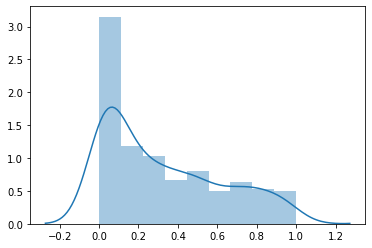

In [14]:
sns.distplot(all_p[0])

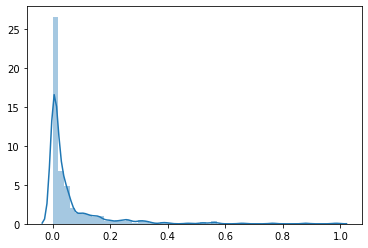

In [15]:
sns.distplot(all_p[2])